In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import kruskal, sem
from scipy import stats
import pandas as pd

from synet.networks import HomogeneousNetwork, merge_networks
from synet.measures import MixingEntropy, PathEntropy, PaintEntropy, AgentEntropy, OverlapParameter
from synet.analysis import entropy_windows, alpha_eff
from synet.visualization import plot_entropy_game
from synet.networks.random import random_two_split_network
from synet.config import measures

In [8]:
np.random.seed(1872631)
n_inter_events=40
n_events = 5000
n_agents=100
dt = 3*n_agents + 1
n_sample=10
n_networks = 300
output_fp = "event_detection.csv"

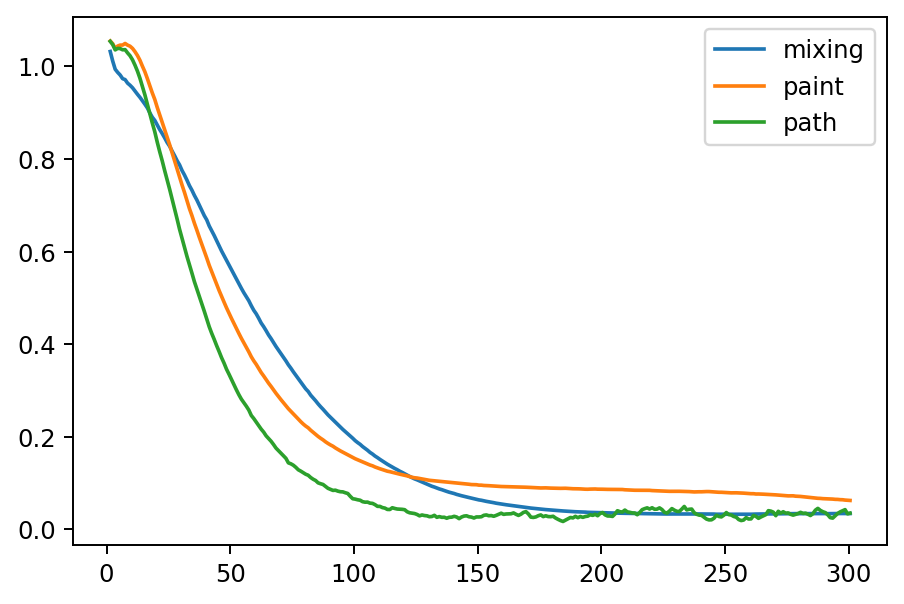

In [11]:
plt.figure(dpi=175)
net = random_two_split_network(n_events, n_inter_events, n_agents)
for measure in [MixingEntropy(), PaintEntropy(), PathEntropy()]:
    entropy, counts = measure._entropy_dt(net, dt)
    plt.plot(*alpha_eff(entropy), label=measure.name)
plt.legend()
plt.show()

In [7]:
net.n_events

5000

In [ ]:
networks = [random_network() for _ in range(n_networks)]

In [ ]:
def detect_peak(entropy):
    entropy_max = np.max(entropy)
    return round(np.mean(np.where(entropy==entropy_max)[0]))

def benchmark_intervals(net, dt):
    cur_event = 0
    l_bounds = []
    u_bounds = []
    events = mix_events(net)
    bench_events = []
    for i_event in range(len(events)):
        if events[i_event] <= dt//2 or events[i_event] >= net.n_events-dt//2:
            continue
        if i_event == 0:
            lower_bound = 0
        else:
            lower_bound = (events[i_event] - events[i_event-1])//2 + events[i_event-1]
        lower_bound = max(dt//2, lower_bound)
        if i_event == len(events)-1:
            upper_bound = net.n_events
        else:
            upper_bound = (events[i_event+1]- events[i_event])//2 + events[i_event]
        upper_bound = min(net.n_events - dt//2, upper_bound)
        l_bounds.append(lower_bound)
        u_bounds.append(upper_bound)
        bench_events.append(events[i_event])
    return np.array((l_bounds, u_bounds)).T, np.array(bench_events)

def detect_all_peaks(entropy, intervals):
    peaks = []
    for lower_bound, upper_bound in intervals:
        peaks.append(lower_bound + detect_peak(entropy[lower_bound:upper_bound]))
    return peaks

def mix_events(net):
    events = np.where(net.event_sources==2)[0]
    cur_mix_events = []
    for ev in events:
        agents = net.participants[ev]
        if np.all(agents<n_agents//2) or np.all(agents>=n_agents//2):
            continue
        cur_mix_events.append(ev)
    return np.array(cur_mix_events, dtype=int)

def average_event_error(measure, networks, dt):
    entropy_t = measure.entropy_t(networks, dt, n_jobs=32)
    avg_error = []
    for i_net, net in enumerate(networks):
        entropy = entropy_t[i_net]
        intervals, events = benchmark_intervals(net, dt)
        peaks = detect_all_peaks(entropy, intervals)
        if len(peaks) > 0:
            avg_error.append(np.mean(np.abs(peaks-events)))
        else:
            avg_error.append(np.nan)
    return np.mean(avg_error), stats.sem(avg_error, nan_policy="omit")

def average_random_error(intervals, events):
    avg_error = []
    for i_event in range(len(intervals)):
        errors = np.arange(intervals[i_event][0] - events[i_event], intervals[i_event][1] - events[i_event])
        avg_error.append(np.mean(np.abs(errors)))
    return np.mean(avg_error)

def get_random_error(networks, dt):
    all_err = []
    for net in networks:
        intervals, events = benchmark_intervals(net, dt)
        all_err.append(average_random_error(intervals, events))
    return np.mean(all_err)


In [ ]:
def create_dataframe(networks):
    all_dt = np.arange(n_agents//4, n_agents*3, n_agents//10)
    all_dt[all_dt %2 == 0] += 1
    df = pd.DataFrame()
    df["dt"] = all_dt
    for measure_name, measure_class in measures.items():
        err = []
        sem = []
        xvals = []
        measure = measure_class()
        for i_dt, dt in enumerate(all_dt):
            if (dt % 2) == 0:
                dt += 1
            xvals.append(dt)
            avg_error, avg_sem = average_event_error(measure, networks, dt)
            err.append(avg_error)
            sem.append(avg_sem)
        df[measure_name] = err
        df[measure_name+"_err"] = sem

    df["random"] = [get_random_error(networks, dt) for dt in all_dt]
    return df

In [ ]:
def plot_data(df, measure_names):
    random = df["random"].values
    dt = df["dt"].values
    for name in measure_names:
        err = df[name].values
        sem = df[name+"_err"].values
        plt.errorbar(dt, 1-err/random, sem/random, label=name)
    plt.legend()
    plt.show()

In [ ]:
try:
    df = pd.read_csv(output_fp)
except FileNotFoundError:
    df = create_dataframe(networks)
    df.to_csv(output_fp, index=False)

plt.figure(dpi=150)
plot_data(df, list(measures))

In [ ]:
# df.to_csv("event_detection.csv")

In [ ]:
# mix_events = np.sort(np.where(net.event_sources==2)[0])
# iso_events = []
# plt.figure(dpi=150)
# plt.ylim(200, 270)
# plt.grid()
# for i_event in range(len(mix_events)):
#     if i_event > 0 and mix_events[i_event]-mix_events[i_event-1] < dt:
#         continue
#     if i_event < len(mix_events)-1 and mix_events[i_event+1]-mix_events[i_event] < dt:
#         continue
#     iso_events.append(mix_events[i_event])
#     start = mix_events[i_event]-dt//2 -1
#     end = mix_events[i_event] + dt//2 +1
#     plt.plot(entropy_t[start:end+1])
# plt.show()


In [ ]:
all_rate_intern = [10, 20, 50, 100]
path_kruskal = []
mix_kruskal = []
path_error = []
mix_error = []

for rate_intern in all_rate_intern:
    cur_d_mix = []
    cur_d_path = []
    for _ in range(n_sample):
        A, event_list, event_participants = create_temporal_network(n_events=n_events, rate_intern=rate_intern)

        eq_start = n_events//10
        eq_end = 9*n_events//10

        close_mixing = np.zeros(n_events, dtype=int)
        for event in event_list[2]:
            start = max(0, event - dt//2)
            end = min(n_events-1, event + dt//2)
            close_mixing[start:end] = 1
        close_mixing[:eq_start] = -1
        close_mixing[eq_end:] = -1
        mix_idx = np.where(close_mixing == 1)[0]
        separate_idx = np.where(close_mixing == 0)[0]


        paint_t = entropy_windows(A, dt=dt, entropy_game=paint_entropy)
        path_t = entropy_windows(A, dt=dt, entropy_game=path_entropy)
        mixing_t = entropy_windows(A, dt=dt, entropy_game=mixing_entropy)

        cur_paint = kruskal(
            paint_t[mix_idx], paint_t[separate_idx], nan_policy="omit"
        ).statistic
        cur_path = kruskal(
            path_t[mix_idx], path_t[separate_idx], nan_policy="omit"
        ).statistic
        cur_mix = kruskal(
            mixing_t[mix_idx], mixing_t[separate_idx], nan_policy="omit"
        ).statistic

        cur_d_mix.append(cur_mix - cur_paint)
        cur_d_path.append(cur_path - cur_paint)
    path_kruskal.append(np.mean(cur_d_path))
    mix_kruskal.append(np.mean(cur_d_mix))
    path_error.append(sem(cur_d_path))
    mix_error.append(sem(cur_d_mix))
    
        

In [ ]:
plt.errorbar(all_rate_intern, mix_kruskal, mix_error, label="mixing")
plt.errorbar(all_rate_intern, path_kruskal, path_error, label="path")
plt.legend()
plt.show()


In [ ]:
plt.figure(dpi=150)
plot_entropy_game(path_results, paint_results, mixing_results, events=event_list[2])
